# Object Detection Using Convolutional Neural Networks

Object detection is a popular computer vision technology that deals with detecting instances of semantic objects (such as humans, animals, buildings and so on) in images or videos, which is a fundamental process to solve more advanced computer vision problems. 

We are going to present a minimal example using ``gluon`` to illustrate how Convolutional Neural Networks can learn to detect objects.

In [1]:
from __future__ import print_function, division
import mxnet as mx
from mxnet import nd
from mxnet import autograd as ag
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.contrib.ndarray import MultiBoxPrior, MultiBoxTarget, MultiBoxDetection
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time

## Prepare data

First of all, we need a toy dataset to play with. Tiny datasets for object detection are rare, however, we can create a dataset for detection task from MNIST!

In [2]:
mnist = mx.test_utils.get_mnist()
batch_size = 64
train_data = mx.io.NDArrayIter(mnist["train_data"], mnist["train_label"], batch_size, shuffle=True)
test_data = mx.io.NDArrayIter(mnist["test_data"], mnist["test_label"], batch_size, shuffle=True)
class_names = [str(x) for x in range(10)]
num_class = 10
print('Class names:', class_names)

Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


Now we grab one batch, and print it to see the internal array shapes

In [3]:
train_data.reset()
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(64, 1, 28, 28)] label shapes: [(64,)]


And we can display the sample image using `matplotlib`

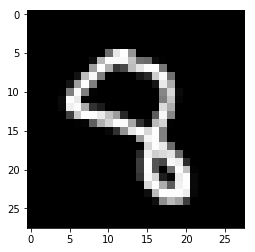

In [4]:
demo = batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
demo = demo.transpose((1, 2, 0))  # we want channel to be the last dimension
plt.imshow(demo[:, :, (0, 0, 0)])  # convert to 3-channels and display
plt.show()

Clearly, the dataset is good for classification task, but we want a dataset for detection. Surely we can produce one by randomly distorting and placing the digits at different positions.

In [5]:
# Make objects not too tricky, so we can save training time
data_shape = 64  # we want a reasonable size as input shape
max_ratio = 1.5  # digits not too wide or tall
min_size = 0.4  # digits not too small
def get_batch(batch):
    batch_size = batch.data[0].shape[0]
    data = mx.nd.zeros((batch_size, 1, data_shape, data_shape))
    label = mx.nd.full((batch_size, 3, 5), -1)
    for k in range(batch_size):
        # generate random width/height for the digits
        w = int(round(random.uniform(min_size, 1) * data_shape))
        h = int(round(random.uniform(min_size, 1) * data_shape))
        # regulate the shape
        if float(w) / h > max_ratio:
            w = int(round(h * max_ratio))
        if float(h) / w > max_ratio:
            h = int(round(w * max_ratio))
        # resize the digit
        orig = batch.data[0][k].reshape((28, 28, 1))
        warped = mx.image.imresize(orig, w, h)
        # randomize the new location
        x0 = random.randint(0, data_shape - w)
        y0 = random.randint(0, data_shape - h)
        # copy warped digits to the canvas
        data[k, 0, y0 : y0 + h, x0 : x0 + w] = warped.reshape((1, 1, h, w))
        # the label is the new location and size of the digits, as [id, xmin, ymin, xmax, ymax]
        cid = batch.label[0][k].asscalar()
        xmin = x0 / data_shape
        ymin = y0 / data_shape
        xmax = (x0 + w) / data_shape
        ymax = (y0 + h) / data_shape
        det_label = mx.nd.array([cid, xmin, ymin, xmax, ymax])
        label[k, 0, :] = det_label.reshape((1, 1, 5))
    return mx.io.DataBatch(data=[data], label=[label], index=batch.index, pad=batch.pad)

Now, with `get_batch` function, we are getting data for detection task!

label for detection: [ 8.        0.25      0.015625  0.96875   0.5     ]


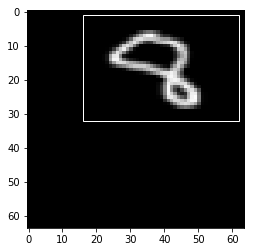

In [6]:
det_batch = get_batch(batch)
demo = det_batch.data[0][0].asnumpy()  # grab the first image, convert to numpy array
demo = demo.transpose((1, 2, 0))  # we want channel to be the last dimension
plt.imshow(demo[:, :, (0, 0, 0)])  # convert to 3-channels and display
label = det_batch.label[0][0][0].asnumpy()
print('label for detection:', label)
xmin, ymin, xmax, ymax = [int(x * data_shape) for x in label[1:5]]
rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 1, 1))
plt.gca().add_patch(rect)
plt.show()

The white bounding box around digit is the desired detection box, namely, ground-truth.

## Detection network

There are multiple convolutional neural network meta-structures specifically designed for object detection. In this section we use Single-Shot Detector (SSD) as an example, and illustrate how a general object detection training/test workflow looks like.

### There are three key points making SSD network different from normal convolutional neural networks:

Details available at https://arxiv.org/abs/1512.02325

* Multi-scale feature maps for detection

* Multiple anchors boxes with different scales and aspect ratios

* Convolutional predictors

### In summary, we need:
* A backbone network producing feature maps in different sizes. We can achieve this by stacking `Conv-BatchNorm-Relu` layers followed by `MaxPooling` layer to reduce the feature map size by a factor of 2. For a 64x64 input image, this could produce feature maps with size 32x32, 16x16, 8x8, 4x4, 2x2, 1x1. 

* Anchor boxes generator. We want multiple anchors with different scales and aspect ratios, so that there always exist an anchor box highly overlaps with an object on image. In this tutorial, we are going to use the following parameters:

    8x8 --> sizes [0.37, 0.447] --> ratios [1, 2, 0.5]

    4x4 --> sizes [0.54, 0.619] --> ratios [1, 2, 0.5]

    2x2 --> sizes [0.71, 0.79]  --> ratios [1, 2, 0.5]

    1x1 --> sizes [0.88, 0.961] --> ratios [1, 2, 0.5]
    
    16x16 feature map might be good for smaller objects, but we skip it in this tutorial in trade of faster convergence.

* 3x3 Convolutional layers are responsible for predict class probabilities, as well as the box deformation predictions. Each convolution channel is responsible for a certain (scale, ratio, feature map) combination.

### Training target in one sentence
![](https://user-images.githubusercontent.com/3307514/28603710-9e7d4d80-717a-11e7-95ed-dd08763fed87.png)

Applying convolutional predictors to feature maps in a sliding window fashion (convolutional built-in characteristics), predicting whether the correspoding anchor is an object (and what class) or background, and how much deformation the corresponding anchor box should transform to cover the object.


In [7]:
class ToySSD(gluon.Block):
    def __init__(self, num_class, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # sizes control the scale of anchor boxes, with decreasing feature map size,
        # the anchor boxes are expected to be larger in design
        self.sizes = [[.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # ratios control the aspect ratio of anchor boxes, here we use 1, 2, 0.5
        self.ratios = [[1,2,.5], [1,2,.5], [1,2,.5], [1,2,.5]]
        num_anchors = [len(x) + len(y) - 1 for x, y in zip(self.sizes, self.ratios)]
        self.num_anchors = num_anchors
        self.num_class = num_class
        with self.name_scope():
            # first build a body as feature
            self.body = nn.HybridSequential()
            # 64 x 64
            # make basic block is a stack of sequential conv layers, followed by
            # a pooling layer to reduce feature map size
            self.body.add(self._make_basic_block(16))
            # 32 x 32
            self.body.add(self._make_basic_block(32))
            # 16 x 16
            self.body.add(self._make_basic_block(64))
            # 8 x 8
            # use cls1 conv layer to get the class predictions on 8x8 feature map
            # use loc1 conv layer to get location offsets on 8x8 feature map
            # use blk1 conv block to reduce the feature map size again
            self.cls1 = nn.Conv2D(num_anchors[0] * (num_class + 1), 3, padding=1)
            self.loc1 = nn.Conv2D(num_anchors[0] * 4, 3, padding=1)
            self.blk1 = self._make_basic_block(64)
            # 4 x 4
            self.cls2 = nn.Conv2D(num_anchors[1] * (num_class + 1), 3, padding=1)
            self.loc2 = nn.Conv2D(num_anchors[1] * 4, 3, padding=1)
            self.blk2 = self._make_basic_block(64)
            # 2 x 2
            self.cls3 = nn.Conv2D(num_anchors[2] * (num_class + 1), 3, padding=1)
            self.loc3 = nn.Conv2D(num_anchors[2] * 4, 3, padding=1)
            # 1 x 1
            self.cls4 = nn.Conv2D(num_anchors[3] * (num_class + 1), 3, padding=1)
            self.loc4 = nn.Conv2D(num_anchors[3] * 4, 3, padding=1)

    def _make_basic_block(self, num_filter):
        """Basic block is a stack of sequential convolution layers, followed by
        a pooling layer to reduce feature map. """
        out = nn.HybridSequential()
        out.add(nn.Conv2D(num_filter, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
        out.add(nn.Conv2D(num_filter, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filter))
        out.add(nn.Activation('relu'))
        out.add(nn.MaxPool2D())
        return out

    def forward(self, x):
        anchors = []
        loc_preds = []
        cls_preds = []
        x = self.body(x)
        # 8 x 8, generate anchors, predict class and location offsets with conv layer
        # transpose, reshape and append to list for further concatenation
        anchors.append(MultiBoxPrior(x, sizes=self.sizes[0], ratios=self.ratios[0]))
        loc_preds.append(nd.flatten(nd.transpose(self.loc1(x), axes=(0, 2, 3, 1))))
        cls_preds.append(nd.flatten(nd.transpose(self.cls1(x), axes=(0, 2, 3, 1))))
        x = self.blk1(x)
        # 4 x 4
        anchors.append(MultiBoxPrior(x, sizes=self.sizes[1], ratios=self.ratios[1]))
        loc_preds.append(nd.flatten(nd.transpose(self.loc2(x), axes=(0, 2, 3, 1))))
        cls_preds.append(nd.flatten(nd.transpose(self.cls2(x), axes=(0, 2, 3, 1))))
        x = self.blk2(x)
        # 2 x 2
        anchors.append(MultiBoxPrior(x, sizes=self.sizes[2], ratios=self.ratios[2]))
        loc_preds.append(nd.flatten(nd.transpose(self.loc3(x), axes=(0, 2, 3, 1))))
        cls_preds.append(nd.flatten(nd.transpose(self.cls3(x), axes=(0, 2, 3, 1))))
        # we use pooling directly here without convolution layers
        x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(2, 2))
        # 1 x 1
        anchors.append(MultiBoxPrior(x, sizes=self.sizes[3], ratios=self.ratios[3]))
        loc_preds.append(nd.flatten(nd.transpose(self.loc4(x), axes=(0, 2, 3, 1))))
        cls_preds.append(nd.flatten(nd.transpose(self.cls4(x), axes=(0, 2, 3, 1))))
        # concat multiple layers
        anchors = nd.reshape(nd.concat(*anchors, dim=1), shape=(0, -1, 4))
        loc_preds = nd.concat(*loc_preds, dim=1)
        cls_preds = nd.reshape(nd.concat(*cls_preds, dim=1), (0, -1, self.num_class+1))
        cls_preds = nd.transpose(cls_preds, axes=(0, 2, 1))
        return [anchors, cls_preds, loc_preds]

ToySSD network takes a batch of images `(64, 1, 64, 64)` as input, and will output three components:

1. Concatenated anchors with shape `(1, 340, 4)` scattered around images with all kinds of scales and aspect ratios. The first dimension is 1, indicating all anchors are shared across batches, second is the number of anchors, the third dimension is for box coordinates (xmin, ymin, xmax, ymax)

2. Concatenated class predictions with shape `(64, 11, 340)`, first dimension is the `batch_size`, second is per-class prediction for `(background, 0, 1, ..., 9)`, the last dimension is number of anchors.

3. Concatenated location predictions with shape `(64, 340 * 4)`.

## Losses

Two types of loss functions are involved here. 
* Cross-entropy loss is typical for softmax classification problems, which serves as classification loss for all anchor boxes. 

* L2Loss is used to penalize incorrect bounding box offsets. We can play with L1Loss, SmoothL1Loss as well.

In [8]:
cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()  # for softmax classification, typical for classification
loc_loss = gluon.loss.L2Loss()  # typical for regression

## Evaluate metrics

Evalute metrics are for collectting training status, which has no effect on training itself.

In [9]:
cls_metric = mx.metric.Accuracy()
loc_metric = mx.metric.MAE()

## Create network

In [10]:
net = ToySSD(num_class)  # create a net to predict 10-class digits

## Set the context

In [11]:
ctx = mx.gpu()  # it takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, which will be slow...')
    ctx = mx.cpu()

## Initalize parameters

In [12]:
net.collect_params().initialize(mx.init.Xavier(magnitude=2.34), ctx=ctx)

## Trainer

In [13]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Start training

In [14]:
epochs = 8  # set larger to get better performance
log_interval = 500
for epoch in range(epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    loc_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        det_batch = get_batch(batch)
        # record gradients
        with ag.record():
            x = det_batch.data[0].as_in_context(ctx)
            y = det_batch.label[0].as_in_context(ctx)
            anchors, cls_preds, loc_preds = net(x)
            z = MultiBoxTarget(*[anchors, y, cls_preds])
            loc_target = z[0]  # loc offset target for (x, y, width, height)
            loc_mask = z[1]  # mask is used to ignore predictions we don't want to penalize
            cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
            # losses
            loss1 = cls_loss(nd.transpose(cls_preds, (0, 2, 1)), cls_target)
            loss2 = loc_loss(loc_preds * loc_mask, loc_target)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply optimizer
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [cls_preds])
        loc_metric.update([loc_target], [loc_preds * loc_mask])
        if i % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = loc_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f' 
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))
    
    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = loc_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
    
# we can save the trained parameters to disk
# net.collect_params().save('ssd_%d.params' % epochs)

[Epoch 0 Batch 0] speed: 63.873648 samples/s, training: accuracy=0.168796, mae=0.025306
[Epoch 0 Batch 500] speed: 731.318177 samples/s, training: accuracy=0.978992, mae=0.014439
[Epoch 0] training: accuracy=0.980648, mae=0.012896
[Epoch 0] time cost: 82.171110
[Epoch 1 Batch 0] speed: 761.799972 samples/s, training: accuracy=0.984007, mae=0.009442
[Epoch 1 Batch 500] speed: 779.345587 samples/s, training: accuracy=0.983687, mae=0.010100
[Epoch 1] training: accuracy=0.984245, mae=0.009854
[Epoch 1] time cost: 75.744250
[Epoch 2 Batch 0] speed: 801.397950 samples/s, training: accuracy=0.986397, mae=0.008735
[Epoch 2 Batch 500] speed: 801.020109 samples/s, training: accuracy=0.986059, mae=0.009199
[Epoch 2] training: accuracy=0.986528, mae=0.009079
[Epoch 2] time cost: 75.629008
[Epoch 3 Batch 0] speed: 799.493253 samples/s, training: accuracy=0.986994, mae=0.009463
[Epoch 3 Batch 500] speed: 797.431730 samples/s, training: accuracy=0.987933, mae=0.008785
[Epoch 3] training: accuracy=0.9

## Display results

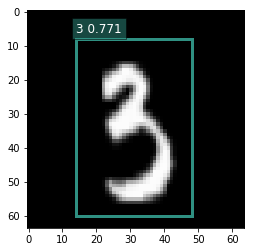

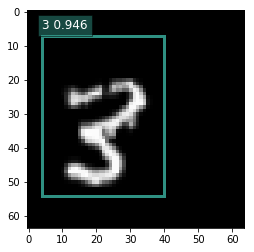

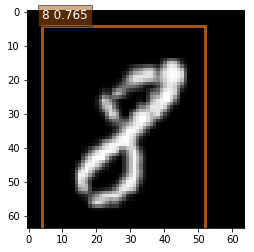

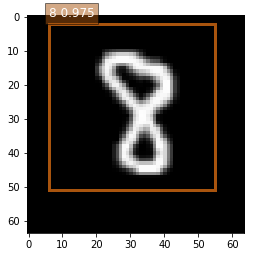

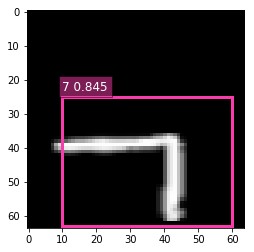

In [17]:
# if pre-trained model is provided, we can load it
# net.collect_params().load('ssd_%d.params' % epochs, ctx)
test_data.reset()
count = 0
limit = 5
pens = dict()
thresh = 0.1
while count < limit:
    x = get_batch(test_data.next()).data[0].as_in_context(ctx)
    # network inference
    anchors, cls_preds, loc_preds = net(x)
    # convert predictions to probabilities
    cls_probs = nd.SoftmaxActivation(cls_preds, mode='channel')
    # apply shifts to anchors boxes, non-maximum-suppression, etc...
    output = MultiBoxDetection(*[cls_probs, loc_preds, anchors], force_suppress=True, clip=True)
    for k, out in enumerate(output.asnumpy()):
        img = x[k].asnumpy().transpose((1, 2, 0))
        img = img[:, :, (0, 0, 0)]
        if count >= limit:
            break
        count += 1
        # display results
        plt.clf()
        plt.imshow(img)
        for det in out:
            cid = int(det[0])
            if cid < 0:
                continue
            score = det[1]
            if score < thresh:
                continue
            if cid not in pens:
                pens[cid] = (random.random(), random.random(), random.random())
            xmin, ymin, xmax, ymax = [int(p * data_shape) for p in det[2:6]]
            rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, 
                                 edgecolor=pens[cid], linewidth=3)
            plt.gca().add_patch(rect)
            text = class_names[cid]
            plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                           bbox=dict(facecolor=pens[cid], alpha=0.5),
                           fontsize=12, color='white')
            plt.show()
                

## Conclusion

Detection is harder than classification, since we want not only class probabilities, but also localizations of different objects including potential small objects. Using sliding window together with a good classifier might be an option, however, we have shown that with a properly designed convolutional neural network, we can do single shot detection which is blazing fast and accurate! 

For whinges or inquiries, [open an issue on  GitHub.](https://github.com/zackchase/mxnet-the-straight-dope)